# IFU Cube Fitting


**Use case:** continuum and emission-line modeling of AGN; 1.47-1.87um.<br>
**Data:** [NIFS](https://www.gemini.edu/instrumentation/current-instruments/nifs) on Gemini; NGC 4151.<br>
**Tools:**  specutils, jdaviz/cubeviz, astropy, matplotlib, bottleneck.<br>
**Cross-intrument:** NIRSpec; potentially MIRI <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/IFU_cube_continuum_fit/) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>

## Introduction

This notebook uses an example 3-D IFU Datacube of the Active Galactic Nucleii NGC 4151 [Storchi-Bergmann et al. 2009,  MNRAS, V 394, pp. 1148-1166](https://ui.adsabs.harvard.edu/abs/2009MNRAS.394.1148S/abstract).  This is a ground-based AO-fed H-band dataset (1.47-1.87um) from the Near-Infrared Integral Field Spectrograph (NIFS) instrument at the Gemini Observatory.  NIFS is a very similar image slicing IFU to JWST NIRSpec.

This notebook performs some simple spectral investigations.  The notebook utilizes [jdaviz/cubviz](https://github.com/spacetelescope/jdaviz) to inspect the dataset and extract 1-D spectra.  The continuum is fit in a region near to the 1.644um [Fe II] emission from the AGN outflow and subtracted.  The centrally compact atomic Hydrogen Brackett 12 feature, which is nearby in wavelength and contaminates the [Fe II] outflow emission, is also fit and removed.  The data sub-cubes of the continuum model and the isolated and continuum subtracted [Fe II] emission are then saved.  These saved data sets will ultimately serve as starting points for the future notebooks in this set.

**Note:** This notebook is designed to analyze the 1.6440 [Fe II] emission but the wavelengths can be altered to fit and remove continuum around any emission line of interest.

## Import Packages
 - time for timing
 - numpy for array processing and math
 - matplotlib.pyplot for plotting images and spectra
 - astropy.io for reading and writing FITS cubes and images
 - astropy.modeling for modeling spectral curves
 - astropy.utils.data for accessing the data
 - specutils.fitting for spectral data fitting
 - specutils Spectrum1D for modeling emission lines
 - jdaviz.app to use cubeviz in the notebook



In [1]:
# load important packages
import os
import time
from IPython.display import YouTubeVideo
import warnings

import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.modeling.functional_models import Gaussian1D
from astropy.utils.data import download_file
from specutils import Spectrum1D
from jdaviz import Cubeviz
from specutils.manipulation import extract_region
from specutils.spectra import SpectralRegion
from regions import PixCoord, CirclePixelRegion
from glue.core.roi import XRangeROI

In [2]:
# load and configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
# Save and Load Objects Using Pickle (needed to get the parameter file at the end)
import pickle


def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

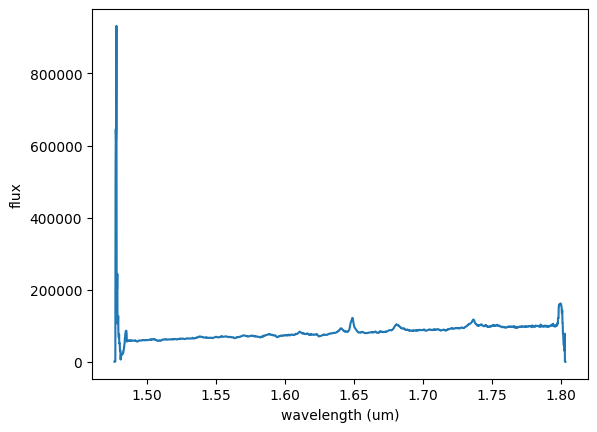

In [4]:
# This cell accesses the datacube file, defines the wavelength grid from header information and then plots a simple
# 1-D collapsed spectrum of the IFU data.

# Read in a 3-D IFU datacube of interest, and header.
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits', cache=True)
cube = fits.getdata(cube_file)
header_cube = fits.getheader(cube_file)

# grab data information and wavelength definitions.
nz, ny, nx = cube.shape
crdelt3 = header_cube['CDELT3']
crval3 = header_cube['CRVAL3']

# define the wavelength grid (microns) from the header (Angstroms)
# and the AGN redshift and the emission line of interest.
wave = ((crdelt3 * (np.arange(0, nz, 1))) + crval3)/10000.0
redshift = 0.00332
emission_line = 1.64400*(1 + redshift)
emission_line_index = (np.abs(wave-emission_line)).argmin()

# make a simple summed 1d spectrum of the full cube
flux1 = np.sum(cube, axis=(1, 2))

# plot the full 1-D spectrum.
plt.figure(0)
plt.plot(wave, flux1)
plt.xlabel('wavelength (um)')
plt.ylabel('flux')
plt.show()

We see that the spectral edges of the summed 1D are 'ratty'.  The 1D spectral array goes beyond the nominal useable data range of the instrument.  We'll ignore the poor spectral regions and focus on the AGN flux.

The [Fe II] feature that we are interested in is the bright, strong emission just shortward of 1.65um.  The contaminating H I Br 12 emission is just blueward of the [Fe II].

We can use this plot window to read wavelength values of interest to define our analysis spectral ranges (see wavelength/flux grid data to the lower right of the plot window).

Special Note - in this particular dataset, a portion of the spectrum on the red side of the [FeII] emission
provides a clean measure of the continuum.  The blue-ward side of the [Fe II]
and HI Brackett 12 emission has other emission and absorption features that make clear continuum ID very 
difficult.  As a result, it is more accurate to do a simple linear fit to the red side of the spectrum rather than
a more expanded spectral region that encompasses the emission..

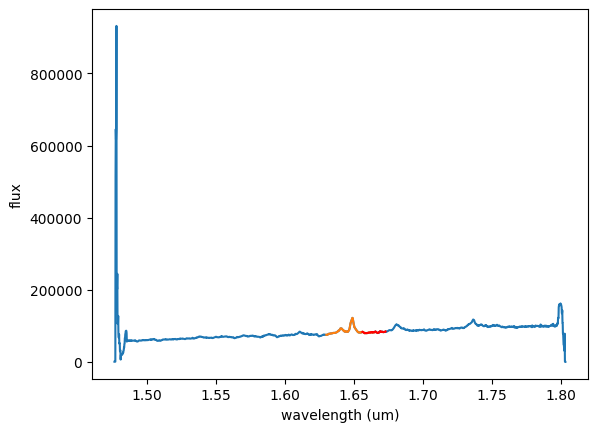

In [5]:
# This cell defines the wavelength regions of interest: around the emission line, and the location
# where you want to fit and remove the continuum very accurately.  Make a plot that shows the regions.

# Here we select a region that includes the emission line
# wavelength plus a small range of continuum around it.  
# Determine these limits by investigating the flux in the above plot.  Read
# the wavelength values off of the plot information at the lower right.

wave_emission_limit1 = 1.630
wave_emission_limit2 = 1.665

# Here we define a spectral range where we will use the
# flux to generate a continuum model.  The flux shape in this
# AGN is quite linear around the redward emission, so we will use only a 
# short segment of the spectrum on the red side of the emission 
# feature.
# We again determine these values by investigating the wavelengths in the
# above plot window.

continuum_limit1 = 1.656
continuum_limit2 = 1.673
  
# Define the wavelength region around the emission - indices
wavemin = (np.abs(wave-wave_emission_limit1)).argmin()
wavemax = (np.abs(wave-wave_emission_limit2)).argmin()

# Define the wavelength region used to fit the continuum flux level  - indices.
continuummin = (np.abs(wave-continuum_limit1)).argmin()
continuummax = (np.abs(wave-continuum_limit2)).argmin()

# Show the region used for the emission line and continuum fit.  Alter the wavelengths 
# above if this doesn't look good.  
plt.figure(1)
plt.plot(wave, flux1)
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax], color='r')
plt.xlabel('wavelength (um)')
plt.ylabel('flux')
plt.show()

### Cubeviz Visualization
You can also visualize images inside a Jupyter notebook using [Cubeviz](https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html)

### Video: 

This Cubeviz Demo is from the official JWST Observer YouTube channel. It shows an example of how to use Cubeviz for a specific science case (not this notebook's science case).

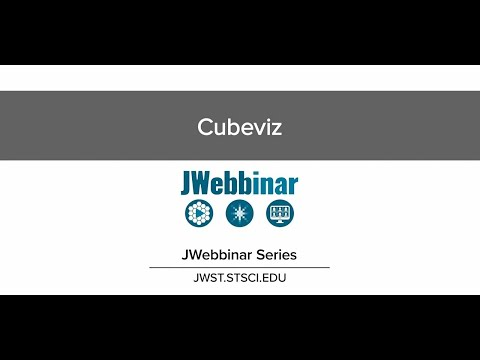

In [6]:
vid = YouTubeVideo("ayb6OkmZUwU")
display(vid)

In [7]:
cubeviz = Cubeviz()
cubeviz.show()

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/v3.10.1/cubeviz/index.html', events=…

In [8]:
# Here, we load the data into the Cubeviz app.
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cubeviz.load_data(fn)

A video is shown below illustrating the procedure.  The following steps are applied:

When you load your cube, you will see a collapsed spectrum of all the spaxels in the spectral viewer at the bottom.

If you draw a region (circle or square) in the flux viewer, you will see a collapsed spectrum of that particular region in the spectral viewer, too. For this example, we want to first define a circular region at the central position of the bright AGN flux, which is at approximately the cube center position.<br>
<img src='./cubeviz_select_subset.png' alt="Select a circular subset on the AGN in the center of the image." width="500"/>

Now, use the flux viewer and again use the 'define circular region of interest' icon to make spectra at two positions associated with the outflow emission in [Fe II].  The redshifted outflow is at approximate x position = 12, y position = 36.  This will be 'Subset 2' and will show up in green in the display. The blueshifted outflow is at approximately x position = 48, y position = 24 in pixel index units.  This will be 'Subset 3' and will show up in blue in the display. _Hint: the coordinates of the cursor are reported at the top of the tool_<br>
<img src='./cubeviz_select_subset_outflow.png' alt="Select a circular subset on each side of the AGN to look at the outflow." width="500"/>

## Defining your Spectral Regions

Next, you will want to define the wavelengths of interest in your spectral viewer for both your line and continuum analysis.  To do this, you will similarly click the 'define region of interest' icon in your spectral viewer and drag a box over the wavelengths you desire. The line emission ('Subset 4' ) should span approximately 1.630 - 1.665 um, and the continuum emission ('Subset 5') should span approximately 1.656 - 1.673 um.<br>
<img src='./cubeviz_select_spectral_subset.png' alt="Select a spectral subset on the emission feature and one on the continuum." width="500"/><br>
_Hint: subsets can be modified in the Subset Tools plugin_

### Some Notes:

* If your cell window requires you to scroll to see the different displays in cubeviz, you can toggle the scroll window in the main menu of the notebook: Cell -> Current Outputs -> Toggle Scrolling

* To better visualize the cube, you can change the display options in the Plot Option plugin.

# Extract Subset Spectrum in Cubeviz Spectrum Viewer

Retrieve the spectra of the user-defined regions from the Spectrum Viewer as a Spectrum1D object. First, we create the regions from the API in case the notebook is not run interactively.

In [9]:
# Create spatial regions
spatial_regions = cubeviz.get_interactive_regions()

if 'Subset 1' not in spatial_regions.keys():
    agn_region = CirclePixelRegion(center=PixCoord(x=29, y=29), radius=6)
    cubeviz.load_regions(agn_region)
if 'Subset 2' not in spatial_regions.keys():
    redshifted_outflow = CirclePixelRegion(center=PixCoord(x=12, y=36), radius=6)
    cubeviz.load_regions(redshifted_outflow)
if 'Subset 3' not in spatial_regions.keys():
    blueshifted_outflow = CirclePixelRegion(center=PixCoord(x=48, y=24), radius=6)
    cubeviz.load_regions(blueshifted_outflow)

spatial_regions = cubeviz.get_interactive_regions()
spatial_regions

{'Subset 1': <CirclePixelRegion(center=PixCoord(x=29, y=29), radius=6)>,
 'Subset 2': <CirclePixelRegion(center=PixCoord(x=12, y=36), radius=6)>,
 'Subset 3': <CirclePixelRegion(center=PixCoord(x=48, y=24), radius=6)>}

In [10]:
# Extract spectra corresponding to the colored regions in cubeviz
spectrum1 = cubeviz.get_data("contents[SCI]", spatial_subset='Subset 1', function="mean") # AGN Center
spectrum2 = cubeviz.get_data("contents[SCI]", spatial_subset='Subset 2', function="mean") # Red shifted component
spectrum3 = cubeviz.get_data("contents[SCI]", spatial_subset='Subset 3', function="mean") # Blue shifted component
spectrum1

<Spectrum1D(flux=[0.0 ... 0.0] ct (shape=(2040,), mean=231.18710 ct); spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [14766.40039062 14768.00057662 14769.60076261 ... 18025.97925293
 18027.57943892 18029.17962492] Angstrom> (length=2040))>

In [11]:
# Extract the line region defined in the spectral viewer
regions = cubeviz.specviz.get_spectral_regions()
        
if "Subset 4" in regions.keys():
    line_region = regions["Subset 4"]
else:
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)
    sv = cubeviz.app.get_viewer('spectrum-viewer')
    sv.toolbar_active_subset.selected = []
    sv.apply_roi(XRangeROI(16300, 16650))

In [12]:
# Extract the continuum region defined in the spectral viewer
if "Subset 5" in regions.keys():
    continuum_region = regions["Subset 5"]
else:
    continuum_region = SpectralRegion(1.656*u.um, 1.673*u.um)
    sv = cubeviz.app.get_viewer('spectrum-viewer')
    sv.toolbar_active_subset.selected = []
    sv.apply_roi(XRangeROI(16560, 16730))

regions = cubeviz.specviz.get_spectral_regions()
regions

{'Subset 4': Spectral Region, 1 sub-regions:
   (16300.0 Angstrom, 16650.0 Angstrom) ,
 'Subset 5': Spectral Region, 1 sub-regions:
   (16560.0 Angstrom, 16730.0 Angstrom) }

In [13]:
# Apply the spectral region
# (creates new collapsed spectra if user did not in jdaviz)
if not spectrum1:
    flux_agn = np.sum(cube[:, (ny//2)-3:(ny//2)+3, (nx//2)-3:(nx//2)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_agn*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_agn = extract_region(tmpspec, line_region)
    spec_agn_continuum = extract_region(tmpspec, continuum_region)    
else: 
    spec_agn = extract_region(spectrum1, line_region)
    spec_agn_continuum = extract_region(spectrum1, continuum_region)

if not spectrum2:
    flux_feii_red = np.sum(cube[:, (36)-3:(36)+3, (12)-3:(12)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_feii_red*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_red = extract_region(tmpspec, line_region)
    spec_feii_red_continuum = extract_region(tmpspec, continuum_region)
else:    
    spec_feii_red = extract_region(spectrum2, line_region)
    spec_feii_red_continuum = extract_region(spectrum2, continuum_region)

if not spectrum3:
    flux_feii_blue = np.sum(cube[:, (28)-3:(28)+3, (50)-3:(50)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_feii_blue*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_blue = extract_region(tmpspec, line_region)
    spec_feii_blue_continuum = extract_region(tmpspec, continuum_region)
else:     
    spec_feii_blue = extract_region(spectrum3, line_region)
    spec_feii_blue_continuum = extract_region(spectrum3, continuum_region)

Text(0, 0.5, 'flux')

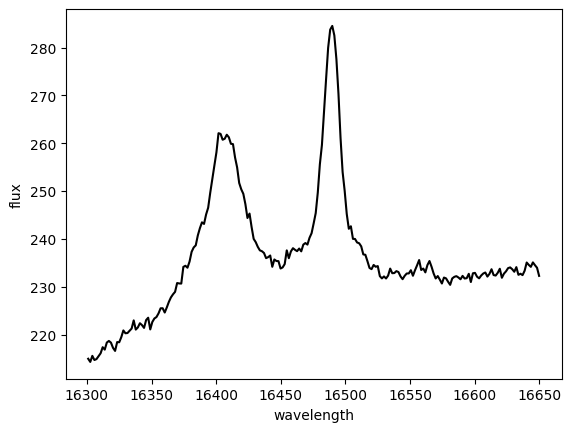

In [14]:
# Visualize new subsets
plt.figure()
plt.plot(spec_agn.spectral_axis, spec_agn.flux, color='black')
plt.xlabel('wavelength')
plt.ylabel('flux')

Text(0, 0.5, 'flux')

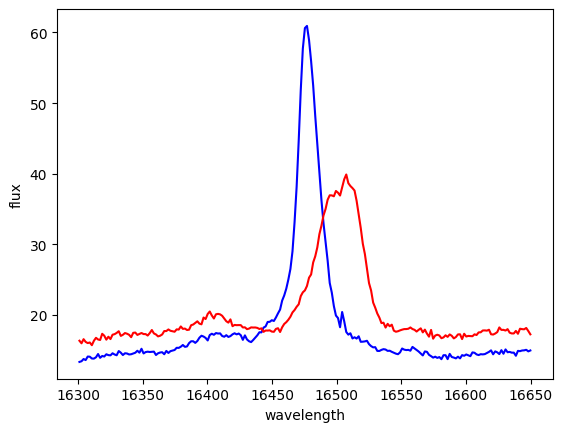

In [15]:
# Visualize new subsets
plt.figure()
plt.plot(spec_feii_blue.spectral_axis, spec_feii_blue.flux, color='b')
plt.plot(spec_feii_red.spectral_axis, spec_feii_red.flux, color='r')
plt.xlabel('wavelength')
plt.ylabel('flux')

## Fit the Continuum at the Spectral Region Location

Open up Model Fitting Plugin. There are a number of fields to fill in and drop down menus to select from.  It is important to keep in mind that the Data menu will provide only spectra to model, while the Spectral Region menu will provide only spectral region subsets to choose.  In other words, you can fit the spectra in specific spectral regions.  If no spectral region is selected, the entire wavelength array will be fit by the mode. <br />

Select Data Cube: Entire cube <br>
Select Spectral Region: Subset 5<br>
Model: Linear1D<br>
ModelID: L<br>
Click "Add component"<br>
Model Parameters: Leave Default<br>
Model Equation Editor: L<br>
Model Label: LinFitCont<br>
Click "Fit model", which fits the collapsed spectrum.<br>
View the fit in the spectral viewer and confirm you are happy with it. <br>
Toggle "Cube fit".
Change the name to LinFitCont_cube and click again "Fit model".<br>

<img src='./cubeviz_model_fitting.png' alt="Model fitting can be set up in the plugin." width="700"/>

The fitted cube can be accessed in the data dropdown of the 2D viewers.

### Use the API instead

In [16]:
models = cubeviz.get_models()

if 'LinFitCont' in models.keys():
    singlemodel = models['LinFitCont']
else:
    # Open model fitting plugin
    plugin_mf = cubeviz.plugins['Model Fitting']
    plugin_mf.open_in_tray()
    # Input the appropriate datasets
    plugin_mf.spatial_subset = 'Entire Cube'
    plugin_mf.spectral_subset = 'Subset 5'
    # Input model component
    plugin_mf.create_model_component(model_component='Linear1D',
                                     model_component_label='L1')
    # Model equation gets populated automatically
    plugin_mf.equation = 'L1'    
    # After we run this, we go to the GUI and check that the fit makes sense
    plugin_mf.add_results.label = 'LinFitCont'
    plugin_mf.cube_fit = False    
    plugin_mf.calculate_fit()

if 'LinFitCont_cube (30, 30)' in models.keys():
    cubemodel = models['LinFitCont_cube']
else:
    # Open model fitting plugin
    plugin_mf = cubeviz.plugins['Model Fitting']
    plugin_mf.open_in_tray()
    # Input the appropriate datasets
    plugin_mf.spatial_subset = 'Entire Cube'
    plugin_mf.spectral_subset = 'Subset 5'
    # Input model component
    plugin_mf.create_model_component(model_component='Linear1D',
                                     model_component_label='L2')
    # Model equation gets populated automatically
    plugin_mf.equation = 'L2'    
    # After we run this, we go to the GUI and check that the fit makes sense
    plugin_mf.cube_fit = True
    plugin_mf.add_results.label = 'LinFitCont_cube'
    plugin_mf.calculate_fit()

WARNING

: Model is linear in parameters; consider using linear fitting methods. [astropy.modeling.fitting]

WARNING

: Model is linear in parameters; consider using linear fitting methods. [astropy.modeling.fitting]

WARNING

: Model is linear in parameters; consider using linear fitting methods. [astropy.modeling.fitting]

In [17]:
models = cubeviz.get_models()
models['LinFitCont_cube (30, 30)']

<Linear1D(slope=0.07431289 ct / Angstrom, intercept=-502.91067924 ct, name='L2')>

## Pulling other data

Note, in cubeviz, you can either return the collapsed spectra as we did above by using the `function`
keyword argument along with (optionally) a `spatial_subset`, or return the entire data cube by omitting
these keywords as below.

In [18]:
# List available data
print(cubeviz.data_labels)

['contents[SCI]', 'LinFitCont', 'LinFitCont_cube']


In [19]:
# Extract SCI cube and continuum model from Cubeviz above and make a continuum subtracted cube
if 'LinFitCont_cube' in cubeviz.app.data_collection:
    tsci = cubeviz.get_data("contents[SCI]")
    tcont_psf_cube = cubeviz.get_data("LinFitCont_cube")
    print('Check shape of the objects')
    print(tsci.shape)
    print(tcont_psf_cube.shape)
    print('Transpose because it inverted RA and Dec')
    sciflux = tsci.flux.value.transpose(1, 0, 2)
    cont_psf_cubeflux = tcont_psf_cube.flux.value.transpose(1, 0, 2)
    sci = Spectrum1D(spectral_axis=tsci.spectral_axis,
                     flux=sciflux*tsci.flux.unit)
    cont_psf_cube = Spectrum1D(spectral_axis=tcont_psf_cube.spectral_axis,
                               flux=cont_psf_cubeflux*tcont_psf_cube.flux.unit)
    # Obtain continuum subtracted cube
    sci_contsub = sci-cont_psf_cube
    # Save to file
    # sci_contsub.write('NGC4151_Hband_ContinuumSubtract.fits', format='wcs1d-fits', overwrite=True)
    # cont_psf_cube.write('NGC4151_Hband_ContinuumPSF.fits', format='wcs1d-fits', overwrite=True)

Check shape of the objects
(59, 59, 2040)
(59, 59, 2040)
Transpose because it inverted RA and Dec


**Developer Note**:<br>
- the cube extracted form cubeviz has RA and Dec flipped when reinjested
- I hit a traceback if I try to save the cubes to file

In [20]:
# Look at the continuum subtracted cube in Cubeviz
if sci_contsub:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cubeviz2 = Cubeviz()
        cubeviz2.load_data(sci_contsub, data_label='Continuum Subtracted')
        cubeviz2.show()

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/v3.10.1/cubeviz/index.html', events=…

### Alternative way to do continuum subtraction using numpy

In [21]:
# Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfn = download_file(cube_file, cache=True)
newheader_cube = fits.getheader(cube_file)

start_time = time.time()

cont_sub_cube = np.zeros([nz, ny, nx])
cont_psf_cube = np.zeros([nz, ny, nx])

for i in range(1, nx-2):
    for j in range(1, ny-2):
        flux1 = cube[:, j, i]      
        cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
        fitval = np.poly1d(cont_fit)
        continuum = fitval(wave)        
        cont_sub_cube[:, j, i] = flux1 - continuum
        cont_psf_cube[:, j, i] = continuum 

del newheader_cube['MODE']
fits.writeto('NGC4151_Hband_ContinuumSubtract_numpy.fits', cont_sub_cube, newheader_cube, overwrite=True)
fits.writeto('NGC4151_Hband_ContinuumPSF_numpy.fits', cont_psf_cube, newheader_cube, overwrite=True)
print('Continuum subtracted cube saved. PSF continuum cube saved.')

Continuum subtracted cube saved. PSF continuum cube saved.


**Developer Note**:
- the new created file cannot be open in Cubeviz

## Fitting your multiple component Gaussian Model

Now we want to investigate an initial fit to the Br 12 emission feature, which is a pesky contaminant nearby in wavelength to our target [Fe II] emission.  The Br 12 is centrally compact and arises only from the nucleus of the AGN, not from the outflow.  Make a plot of the fit results.<br />

First, select the wavelength region of interest following a similar procedure as performed at the top.  There is no option to set the spectral regions to a user input, so we recommend zooming in and drawing by eye.  The line emission ('Subset 1' ) should again span approximately 1.630 - 1.665 um.<br>
<img src='./cubeviz2_subset.png' alt="Select a spectral subset on the 3-line emission feature around 1.54 microns." width="500"/><br>

For this example, we recommend setting up a 3 component gaussian model with the following inputs<br />
Open up Model Fitting Plugin. There are a number of fields to fill in and drop down menus to select from.  It is important to keep in mind that the Data menu will provide only spectra to model, while the Spectral Region menu will provide only spectral region subsets to choose.  In other words, you can fit the spectra in specific spectral regions.  If no spectral region is selected, the entire wavelength array will be fit by the mode. <br />

Data: Entire Cube<br />
Spectral region: Subset 1<br />
Model: Three different Gaussians with ModelID's set to G1, G2, and G3<br />
Model Parameters: <br />
G1: stdev=8, mean=16410<br />
G2: stdev=7, mean=16480<br />
G3: stdev=50, mean=16460<br />
You can turn on the 'Fixed' option if you need to, but these numbers should provide a good starting guess for the fit.<br />
Model Equation Editor: G1+G2+g3<br />
Model Label: GaussAll<br />
<br />
Hit Fit, which fits the collapsed spectrum.<br />
<img src='./cubeviz2_modelfit1.png' alt="Prepare the fit parameters with 3 Gaussian curves and fit the collapsed spectrum." width="500"/><br>
View the fit in the spectral viewer and confirm you are happy with it.  Modify if necessary. <br />
Then remove the 'Fixed' options, toggle Cube Fit, change the name to GaussAll_cube, and run again.<br />
<img src='./cubeviz2_modelfit2.png' alt="Prepare the fit parameters with 3 Gaussian curves and fit the collapsed spectrum." width="500"/><br>

This will again create two models that can now be accessed within the Data Dropdown menus:<br />
A 1D linear fit of the lines in the collapsed cube.<br />
A 3D linear fit of the lines for each spaxel in the cube.<br />

Wow, that multi-component fit looks great.  Good deal.

Now we're going to use the continuum psf cube from a prior cell  with the Brackett model created in the above cell to create a full 3-D model of the central emission that isn't caused by the outflow [Fe II].

**Developer Note**:<br>
- the fit to the full cube gets stuck and never ends

### Exercise
Now you can try to adapt the code shown above to run the model fitting from the API!

_Hint:_<br>
`plugin_mf.create_model_component(model_component='Gaussian1D', model_component_label='G1')`<br>
`plugin_mf.set_model_component('G1', 'mean', value=16410)`

In [22]:
# Your code

### Extract what we need from Cubeviz

In [23]:
# Extract the spectral regions defined in the spectral viewer
regions = cubeviz2.specviz.get_spectral_regions()
print(regions)

if "Subset 1" in regions.keys():
    line_region = regions["Subset 1"]
else:
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)

{}


In [24]:
# List available data
alldata = cubeviz2.app.data_collection
print(alldata)
print()
# List spectra available in spectrum-viewer
spec = cubeviz2.specviz.get_spectra()
print(spec)

DataCollection (1 data set)
	  0: Continuum Subtracted[FLUX]

{'Continuum Subtracted[FLUX]': <Spectrum1D(flux=[-49521.14699503449 ... -105655.86809804464] ct (shape=(2040,), mean=5176.47242 ct); spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [14766.40039062 14768.00057662 14769.60076261 ... 18025.97925293
 18027.57943892 18029.17962492] Angstrom> (length=2040))>}


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/jdaviz/configs/specviz/helper.py:131: UserWarning: Applying the value from the redshift slider to the output spectra. To avoid seeing this warning, explicitly set the apply_slider_redshift keyword option to True or False.
  warnings.warn("Applying the value from the redshift "


In [25]:
# Get gauss model spectrum and model cube
all_spec = cubeviz2.get_data('Continuum Subtracted[FLUX]', function='mean') # AGN Center Data Cube

if 'GaussAll' in alldata:
    gauss_spec = cubeviz2.get_data('GaussAll', function='mean') # AGN Center Model Spec
    print('Model spectrum 1D available')
    print(gauss_spec)
else:
    gauss_spec = False
    print('No GaussAll model created')

print()

if 'GaussAll_cube' in alldata:
    gauss_cube = cubeviz2.get_data('GaussAll_cube') # AGN Center Model Cube
    params = cubeviz2.get_model_parameters()
    print('Model spectrum 3D available')
else:
    gauss_cube = False
    params = False
    print('No GaussAll_cube model created')

print()

# Check to see if user used Cubeviz (above), and, if not, read in premade data
if gauss_cube is False:
    # Get both the model cube and the continuum cube not created with Cubeviz
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_model_cube.fits', cache=False)
    gauss_cube = fits.getdata(fn)
    print('Shape of downloaded model cube: ', gauss_cube.shape)
    fn_continuum = 'NGC4151_Hband_ContinuumPSF_numpy.fits'
    continuum_cube = fits.open(fn_continuum, memmap=False)
    newfull_header = fits.getheader(fn_continuum)
    continuum_data = continuum_cube[0].data
    print('Shape of downloaded continuum cube: ', continuum_data.shape)
else:
    print('Shape of created model cube: ', gauss_cube.shape)
    continuum_data = sci # Created in Cubeviz1
    print('Shape of created continuum cube: ', continuum_data.shape)

print()
if params is False:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_params.pkl', cache=True)
    params = load_obj(fn)
    print('Keys of downloaded model parameters: ', params.keys())
else:
    print('Keys of created model parameters: ', params.keys())

print()

if not all_spec:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/all_spec.fits', cache=False)
    all_spec = Spectrum1D.read(fn)
    print('Shape of downloaded continuum subtracted spectrum: ', all_spec.shape)
else:
    print('Shape of created continuum subtracted spectrum: ', all_spec.shape)

print()

if gauss_spec is False:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_spec.fits', cache=False)
    gauss_spec = Spectrum1D.read(fn)
    print('Shape of downloaded model spectrum: ', gauss_spec.shape)
else:
    print('Shape of created model spectrum: ', gauss_spec.shape)

No GaussAll model created

No GaussAll_cube model created



Shape of downloaded model cube:  (2040, 59, 59)
Shape of downloaded continuum cube:  (2040, 59, 59)



Keys of downloaded model parameters:  dict_keys(['GaussAll', 'GaussAll_3d'])

Shape of created continuum subtracted spectrum:  (2040,)



Shape of downloaded model spectrum:  (2040,)


In [26]:
# Overwrite gauss model with only 2 of the components of interest
gauss_cube_2component = gauss_cube*0

model_label = "GaussAll_3d" # Change this when cube model fitting converges

nz, ny, nx = gauss_cube_2component.shape
for i in range(0, nx-1):
    for j in range(0, ny-1):
        amp1 = params[model_label]['amplitude_0'][i][j]
        amp2 = params[model_label]['amplitude_2'][i][j]
        m1 = params[model_label]['mean_0'][i][j]
        m2 = params[model_label]['mean_2'][i][j]
        stdev1 = params[model_label]['stddev_0'][i][j]
        stdev2 = params[model_label]['stddev_2'][i][j]
        g1 = Gaussian1D(amplitude=amp1*u.Unit('count'), mean=m1*u.m, stddev=stdev1*u.m)
        g2 = Gaussian1D(amplitude=amp2*u.Unit('count'), mean=m2*u.m, stddev=stdev2*u.m)
        gauss_cube_2component[:, i, j] = g1(all_spec.spectral_axis)+g2(all_spec.spectral_axis)

In [27]:
# Add the continuum cube to the new model cube
full_model = gauss_cube_2component + continuum_data
print(continuum_data.shape)

(2040, 59, 59)


In [28]:
# Subtract the model to create the final cube where the [Fe II] emission is isolated.
# Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfinalsub_header = fits.getheader(cube_file)

with fits.open(cube_file, memmap=False) as original_cube:
    original_data = original_cube['SCI'].data
    final_sub_cube = original_data - full_model
    print(original_data.shape)

(2040, 59, 59)


In [29]:
# Delete any existing output in current directory
if os.path.exists("NGC4151_Hband_FinalSubtract.fits"):
    os.remove("NGC4151_Hband_FinalSubtract.fits")
else:
    print("The file does not exist")

if os.path.exists("NGC4151_Hband_ContinuumandBrackettModel.fits"):
    os.remove("NGC4151_Hband_ContinuumandBrackettModel.fits")
else:
    print("The file does not exist")

The file does not exist
The file does not exist


In [30]:
del newfinalsub_header['MODE']

fits.writeto('NGC4151_Hband_ContinuumandBrackettModel.fits', full_model, newfull_header, overwrite=True)
fits.writeto('NGC4151_Hband_FinalSubtract.fits', final_sub_cube, newfinalsub_header, overwrite=True)
print('Continuum subtracted cube saved. PSF continuum cube saved.')

Continuum subtracted cube saved. PSF continuum cube saved.


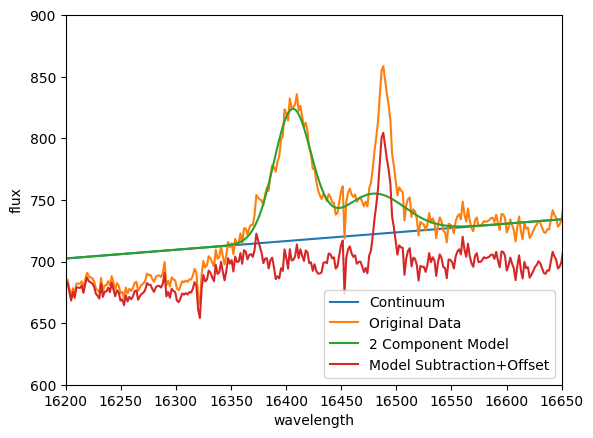

In [31]:
# Make the final plots to illustrate the original spectrum, model fits, and final continuum+gassian subtracted cube
plt.figure()
plt.xlim([16200, 16650])
plt.ylim([600, 900])
plt.plot(all_spec.spectral_axis, continuum_data[:, 30, 30], label='Continuum')
plt.plot(all_spec.spectral_axis, original_data[:, 30, 30], label='Original Data')
plt.plot(all_spec.spectral_axis, full_model[:, 30, 30], label='2 Component Model')
plt.plot(all_spec.spectral_axis, final_sub_cube[:, 30, 30]+700, label='Model Subtraction+Offset')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.show()